# CATBoost

In [28]:
import pandas as pd
import numpy as np
from numpy import sqrt
from catboost import CatBoostClassifier, Pool
from numpy import argmax
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Dataframes

In [29]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar.csv', index_col=0, low_memory=False)

## Tratamento

In [30]:
# variáveis para junção
df_public['data_ref'] = df_public['hora_ref'].apply(lambda x: x[:7])
df_metar['date'] = df_metar['date'].apply(lambda x: x[:7])

In [31]:
df_model = df_public.merge(df_metar, how='left', left_on=['metar', 'data_ref'], right_on=['meta', 'date'])

In [32]:
df_model = df_model[~df_model.url_img_satelite.isnull()]

In [33]:
# variáveis de data
df_model['ano'] = np.int64(df_model['hora_ref'].str[:4])
df_model['mes'] = np.int64(df_model['hora_ref'].str[5:7])
df_model['dia'] = np.int64(df_model['hora_ref'].str[8:10])
df_model['hora'] = np.int64(df_model['hora_ref'].str[11:13])

# variáveis categóricas
df_model['origem'] = df_model['origem'].astype('category')
df_model['destino'] = df_model['destino'].astype('category')

cat_columns = df_model.select_dtypes(['category']).columns
df_model[cat_columns] = df_model[cat_columns].apply(lambda x: x.cat.codes)

## Seleção de variáveis

In [34]:
df_model = df_model[[
    'ano',
    'mes',
    'dia',
    'hora',
    'origem',
    'destino',
    'prev_troca_cabeceira',
    'troca_cabeceira_hora_anterior',
    'espera',
    'latitude',
    'longitude',
    'elevation',
    'wind_direction',
    'wind_speed',
    'visibility',
    'low_cloud_level',
    'cloud_coverage',
    'air_temperature',
    'dew_point_temperature',
    'altimeter',
    'current_wx1_symbol',
    'current_wx2_symbol',
    'current_wx3_symbol',
    'air_pressure_at_sea_level',
    'eastward_wind',
    'northward_wind'
]]

## Datasets de Treino e Teste

In [35]:
# Dataframe para envio na competição

df_test_final = df_model[df_model.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_model[~df_model.espera.isnull()]
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.10, random_state=42, stratify=y_train_inicial)

In [36]:
train_pool = Pool(X_train, 
                  label=y_train,
                  cat_features=['origem','destino'])
test_pool = Pool(X_test,
                 label=y_test,
                 cat_features=['origem','destino'])

## Parâmetros

In [40]:
space={'iterations': hp.quniform("iterations", 3, 20, 1),
        'depth' : hp.quniform('depth', 1, 12, 1),
        'learning_rate': hp.uniform('learning_rate', 0.1, 1),
        'treshold': hp.uniform('treshold', 0.5,  0.8)
    }

In [38]:
# Classifier:
def hyperparameter_tuning(space):
    model = CatBoostClassifier(iterations=int(space['iterations']),
                        depth=int(space['depth']),
                        learning_rate=space['learning_rate'],
                        loss_function='Logloss',
                        verbose=False)
    
    model.fit(train_pool, eval_set=test_pool)

    pred = model.predict(X_test)
    auc = roc_auc_score(y_test, pred>space['treshold'])

    print('Atrasados: ' + str(pred.sum()) + ' || '+ "AUC: " + str(auc))
    #change the metric if you like
    return {'loss': 1 - auc, 'status': STATUS_OK, 'model': model}

In [41]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)
print(best)

Atrasados: 4.0 || AUC: 0.5027060689865611             
Atrasados: 7.0 || AUC: 0.5026329410614442                                       
Atrasados: 0.0 || AUC: 0.5                                                      
Atrasados: 44.0 || AUC: 0.533972118182248                                       
Atrasados: 0.0 || AUC: 0.5                                                      
Atrasados: 0.0 || AUC: 0.5                                                     
Atrasados: 0.0 || AUC: 0.5                                                     
Atrasados: 0.0 || AUC: 0.5                                                     
Atrasados: 0.0 || AUC: 0.5                                                     
Atrasados: 1.0 || AUC: 0.5013774104683195                                      
Atrasados: 16.0 || AUC: 0.512226062389603                                       
Atrasados: 4.0 || AUC: 0.5027060689865611                                       
Atrasados: 0.0 || AUC: 0.5                                 

## Treino

In [159]:
bst = CatBoostClassifier(iterations=20,
                        depth=12,
                        learning_rate=0.3,
                        loss_function='Logloss',
                        verbose=True)




_ = bst.fit(train_pool, eval_set=test_pool, verbose=2000)

Step #1 out of 1
0:	learn: 0.2606783	test: 0.2613537	best: 0.2613537 (0)	total: 348ms	remaining: 6.62s
1:	learn: 0.1431333	test: 0.1441813	best: 0.1441813 (1)	total: 687ms	remaining: 6.19s
2:	learn: 0.1041172	test: 0.1053807	best: 0.1053807 (2)	total: 754ms	remaining: 4.27s
3:	learn: 0.0876855	test: 0.0897688	best: 0.0897688 (3)	total: 1.12s	remaining: 4.49s
4:	learn: 0.0795814	test: 0.0828482	best: 0.0828482 (4)	total: 1.52s	remaining: 4.56s
5:	learn: 0.0755905	test: 0.0792875	best: 0.0792875 (5)	total: 1.9s	remaining: 4.43s
6:	learn: 0.0749385	test: 0.0786286	best: 0.0786286 (6)	total: 1.93s	remaining: 3.59s
7:	learn: 0.0723361	test: 0.0766481	best: 0.0766481 (7)	total: 2.31s	remaining: 3.47s
8:	learn: 0.0701334	test: 0.0755884	best: 0.0755884 (8)	total: 2.7s	remaining: 3.3s
9:	learn: 0.0686987	test: 0.0750164	best: 0.0750164 (9)	total: 3.09s	remaining: 3.09s
10:	learn: 0.0677495	test: 0.0746443	best: 0.0746443 (10)	total: 3.48s	remaining: 2.85s
11:	learn: 0.0660652	test: 0.0741005	b

## Teste

In [160]:
y_pred = bst.predict_proba(X_test, )[:,1]

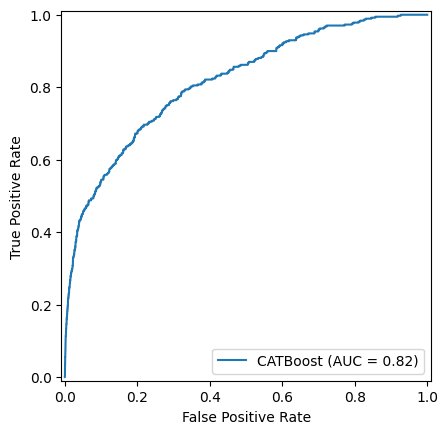

In [161]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='CATBoost')
display.plot()
plt.show()

## Otimização do Threshold Probabilístico

### ROC

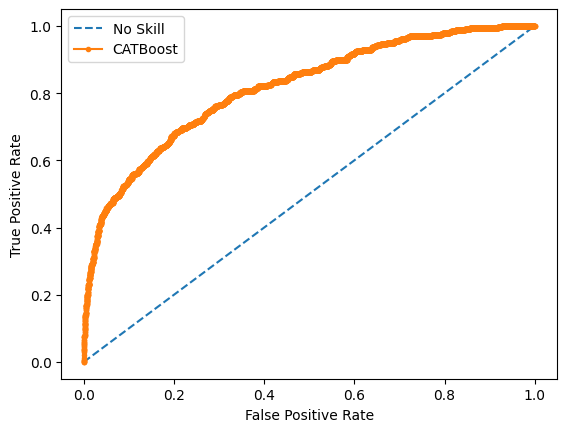

In [162]:
# calcula a curva
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# grafico 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CATBoost')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [163]:
# calcula o melhor ponto 
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)


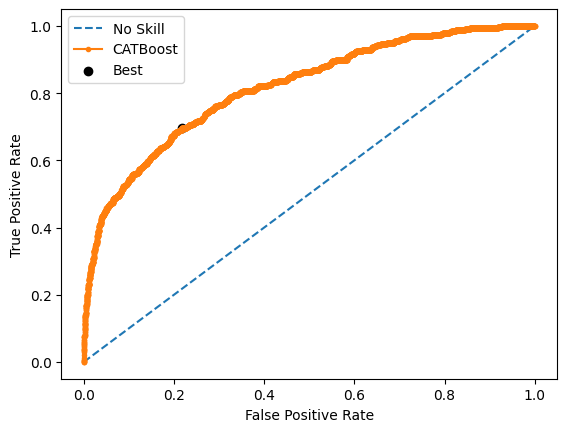

In [164]:
# plota o melhor ponto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CATBoost')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [165]:
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.017446, G-Mean=0.738


### PRC

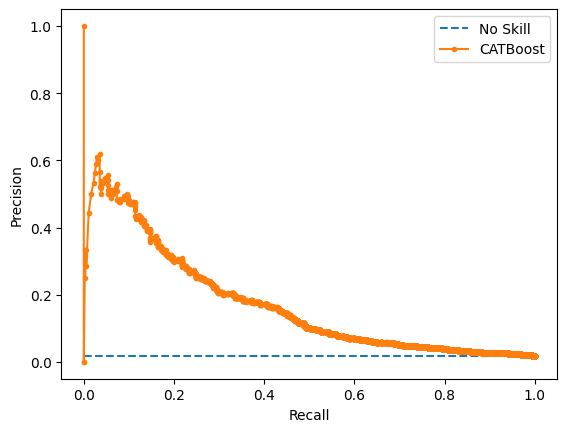

In [166]:
# calcula a curva
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# grafico 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='CATBoost')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [167]:
# medida F
fscore = (2 * precision * recall) / (precision + recall + 0.00001)

# índice do maior F
ix = argmax(fscore)

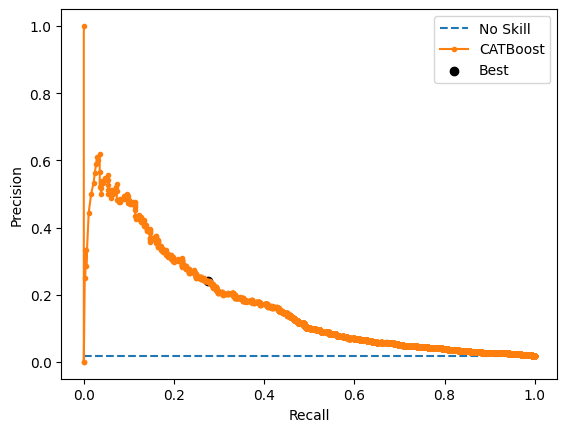

In [168]:
# plota o melhor ponto
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='CATBoost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [169]:
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.109036, F-Score=0.258


## Submissão

In [170]:
# ids
sub = df_public[df_public.espera.isnull()].drop('espera',axis=1).flightid

# threshold escolhido
threshold = 0.058

# submissao
sub = pd.DataFrame(sub)
y_pred = bst.predict_proba(df_test_final)[:,1]
sub['espera'] = np.int8(y_pred > threshold)

# informacoes
print(f'{sub.espera.sum()} de {sub.shape[0]} voos classificados como atrasados com threshold {threshold}')


sub.to_csv('submissions/submission_catboost.csv', index=False)

3297 de 90720 voos classificados como atrasados com threshold 0.058
